# Prophet Modelling Based on Product

In [2]:
# basic imports
import pandas as pd
import numpy as np
from datetime import datetime
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from pylab import rcParams
from sklearn.model_selection import TimeSeriesSplit
import holidays
from prophet import Prophet
from prophet.diagnostics import cross_validation
%matplotlib inline

# import modules
from modules.time_series_functions import resample_series # (series, time_period='day', measure='revenue')
from modules.time_series_functions import create_date_features # (timeseries_df)
from modules.time_series_functions import add_lagged_features # (timeseries_df, num_lag)

# metrics
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
from statsmodels.tools.eval_measures import rmse
from prophet.plot import add_changepoints_to_plot

# settings
import warnings
warnings.filterwarnings('ignore')

From our EDA notebook we were able to visualize the most sales by products. The number 

## Forecast Product Sales Revenue

In [3]:
# loading in dataset:
df = pd.read_csv(r'C:\Users\Jagvir Dhesi\lighthouselabs\projects\demand-prediction-project\data\cleaned_data.csv', parse_dates=['date'])
df.head()

,order_id,date,item_code,quantity,unit_price,unit_cogs,country,item_name,style,name,group0,group1,group2,category,gender,age,sales_revenue,gross_profit,profit_margin,region
0,2000093388,2020-04-24,ZB00089178,1,5.829845,2.209302,Czech Republic,Team LIGA Socks CORE,70344113,Puma,Apparel,Socks,Football socks,football,unisex,adults,5.829845,3.620543,0.621036,Central Europe
1,1900182328,2019-11-04,ZB00089178,1,5.686483,0.000000,Slovakia,Team LIGA Socks CORE,70344113,Puma,Apparel,Socks,Football socks,football,unisex,adults,5.686483,5.686483,1.000000,Central Europe
2,1900186164,2019-11-10,ZB00089178,1,4.965116,2.373643,Czech Republic,Team LIGA Socks CORE,70344113,Puma,Apparel,Socks,Football socks,football,unisex,adults,4.965116,2.591473,0.521936,Central Europe
3,2000058563,2020-03-07,ZB00089178,1,4.965116,2.209302,Czech Republic,Team LIGA Socks CORE,70344113,Puma,Apparel,Socks,Football socks,football,unisex,adults,4.965116,2.755814,0.555035,Central Europe
4,2000297106,2020-11-24,ZB00089178,1,4.772868,2.364341,Czech Republic,Team LIGA Socks CORE,70344113,Puma,Apparel,Socks,Football socks,football,unisex,adults,4.772868,2.408527,0.504629,Central Europe


### Data Preperation


In [4]:
# create filter to choose product of choice:
products = ['Running shoes', 'Pants', 'T-Shirts', 'Football shoes', 'Socks', 'Other Footwear', 'Sweatshirts', 'Jackets', 'Jerseys', 'Fitness Shoes']

product_of_choice = products[0] # replace with product index of choice from above list ( 0 = 'Running shoes')

product_name = product_of_choice

product_filters = df['group1'] == product_name

df_product = df[product_filters]

In [5]:
df_product.head()

,order_id,date,item_code,quantity,unit_price,unit_cogs,country,item_name,style,name,group0,group1,group2,category,gender,age,sales_revenue,gross_profit,profit_margin,region
657,2000093390,2020-04-24,ZB00047919,1,130.661628,72.582558,Czech Republic,UltraBOOST 19 m,g27514,adidas,Footwear,Running shoes,NaN,running,men,adults,130.661628,58.079070,0.444500,Central Europe
658,2000143583,2020-06-22,ZB00047919,1,100.761732,67.790698,France,UltraBOOST 19 m,g27514,adidas,Footwear,Running shoes,NaN,running,men,adults,100.761732,32.971035,0.327218,Western Europe
659,2000151496,2020-07-03,ZB00047919,1,122.823378,67.790698,Romania,UltraBOOST 19 m,g27514,adidas,Footwear,Running shoes,NaN,running,men,adults,122.823378,55.032680,0.448064,Eastern Europe
660,2000154689,2020-07-08,ZB00047919,1,123.001868,67.790698,Romania,UltraBOOST 19 m,g27514,adidas,Footwear,Running shoes,NaN,running,men,adults,123.001868,55.211170,0.448864,Eastern Europe
661,1900134447,2019-08-30,ZB00047919,1,107.598062,0.077519,Czech Republic,UltraBOOST 19 m,g27514,adidas,Footwear,Running shoes,NaN,running,men,adults,107.598062,107.520543,0.999280,Central Europe


In [6]:
df_product = resample_series(df_product, 'day', 'revenue')
df_product.head()

,date,sales_revenue
0,2019-06-01,414.715662
1,2019-06-02,0.000000
2,2019-06-03,237.346124
3,2019-06-04,21472.842993
4,2019-06-05,9736.911843


In [7]:
# rename the columns to 'ds' and 'y'
df_product = df_product.rename(columns={'date': 'ds', 'sales_revenue': 'y'})

In [8]:
train = df_product[:int(df_product.shape[0]*0.70)]
test = df_product[int(df_product.shape[0]*0.70):]

print(train.shape)
print(test.shape)

(671, 2)
(288, 2)


In [9]:
print(f"Train date range: {train['ds'].min()} to {train['ds'].max()}")

Train date range: 2019-06-01 00:00:00 to 2021-04-01 00:00:00


In [10]:
print(f"Test date range: {test['ds'].min()} to {test['ds'].max()}")

Test date range: 2021-04-02 00:00:00 to 2022-01-14 00:00:00


### Model

In [11]:
# create a Prophet model instance
model = Prophet(daily_seasonality=False)
model.fit(train)

00:47:36 - cmdstanpy - INFO - Chain [1] start processing
00:47:36 - cmdstanpy - INFO - Chain [1] done processing


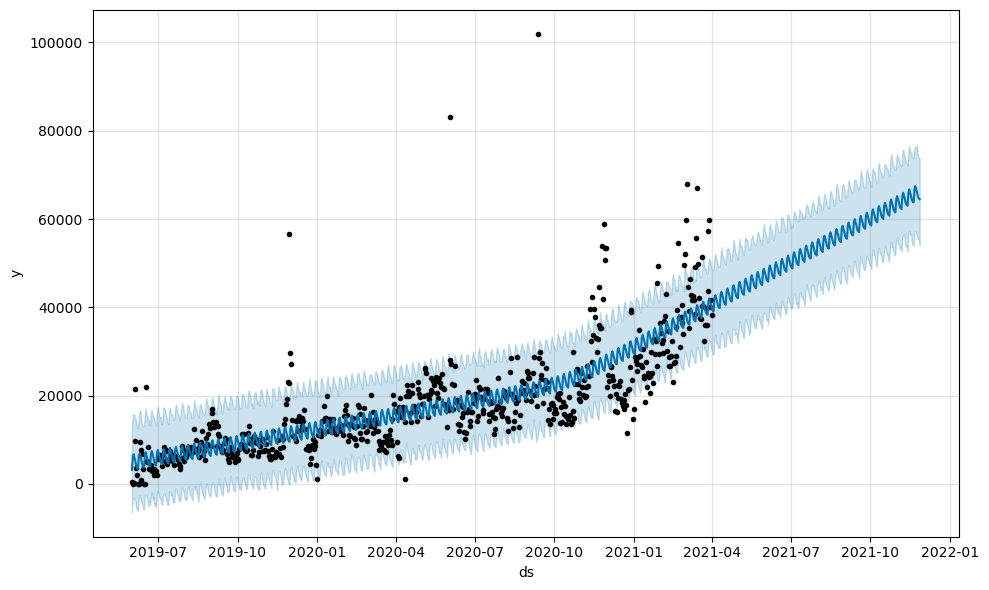

In [12]:
# create a dataframe with future dates to make predictions for
future = model.make_future_dataframe(periods=240, freq='D')

forecast = model.predict(future)

fig = model.plot(forecast)

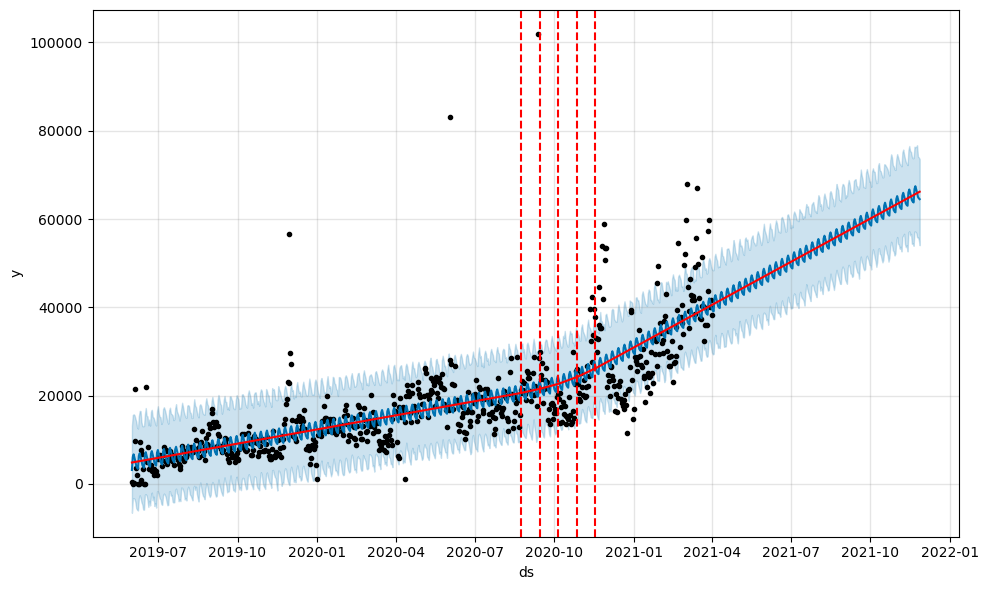

In [13]:
# show change points (where trend changes)
fig = model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model, forecast)

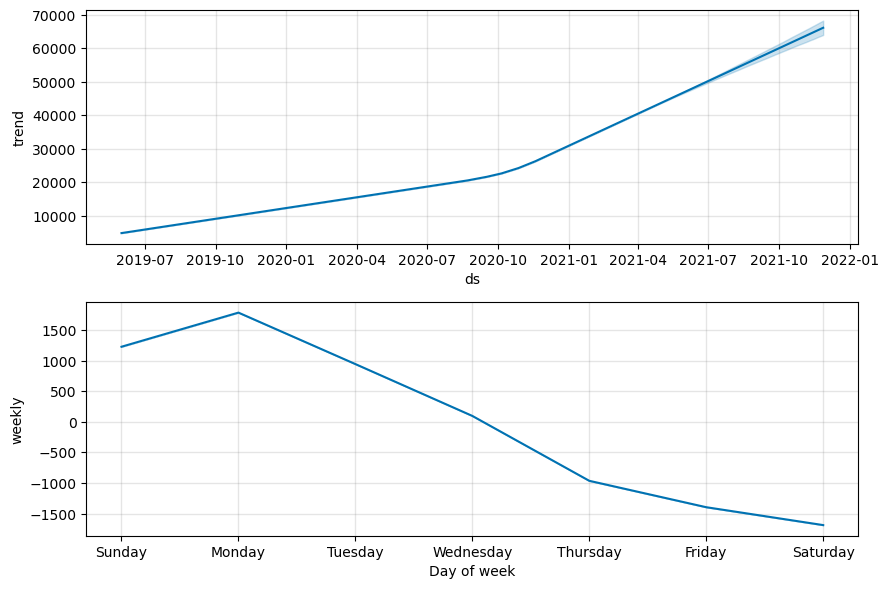

In [14]:
fig = model.plot_components(forecast)

### Hyperparameter Tuning


In [15]:
import itertools

param_grid = {'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
              'seasonality_prior_scale': [0.01, 0.02, 0.1, 1.0],
              'seasonality_mode': ['additive', 'multiplicative'],
             'holidays_prior_scale': [0.01, 0.1, 1.0]}

### Final Model

In [17]:
final_model = Prophet(daily_seasonality=False, seasonality_mode='multiplicative', 
                    seasonality_prior_scale=0.01, holidays_prior_scale=0.01, changepoint_prior_scale=0.01)

final_model.fit(train)

00:48:24 - cmdstanpy - INFO - Chain [1] start processing
00:48:24 - cmdstanpy - INFO - Chain [1] done processing


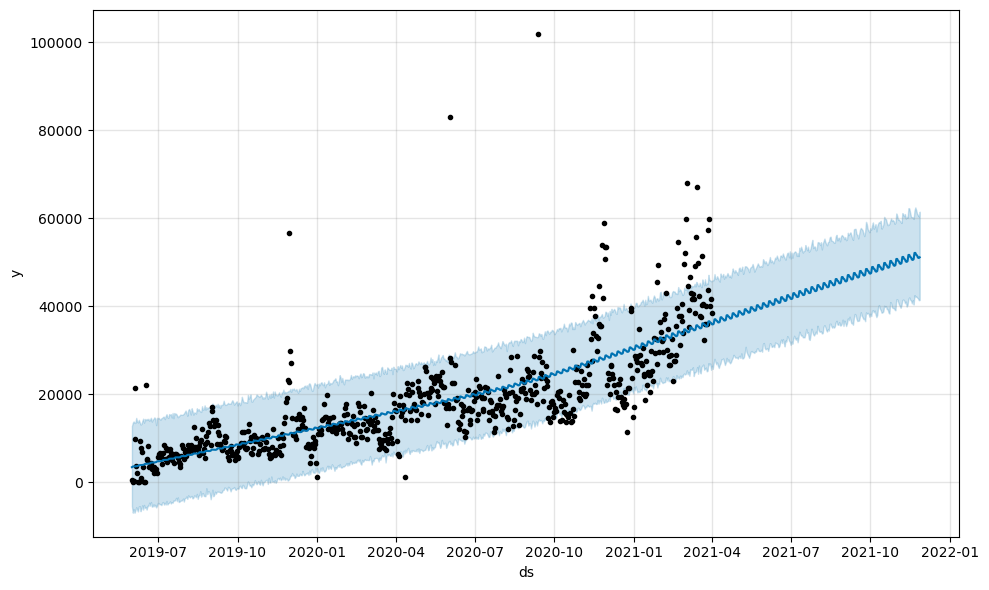

In [18]:
final_future = final_model.make_future_dataframe(periods=240, freq='D')

final_forecast = final_model.predict(final_future)

fig = final_model.plot(final_forecast)

Text(118.97222222222221, 0.5, 'Sales')

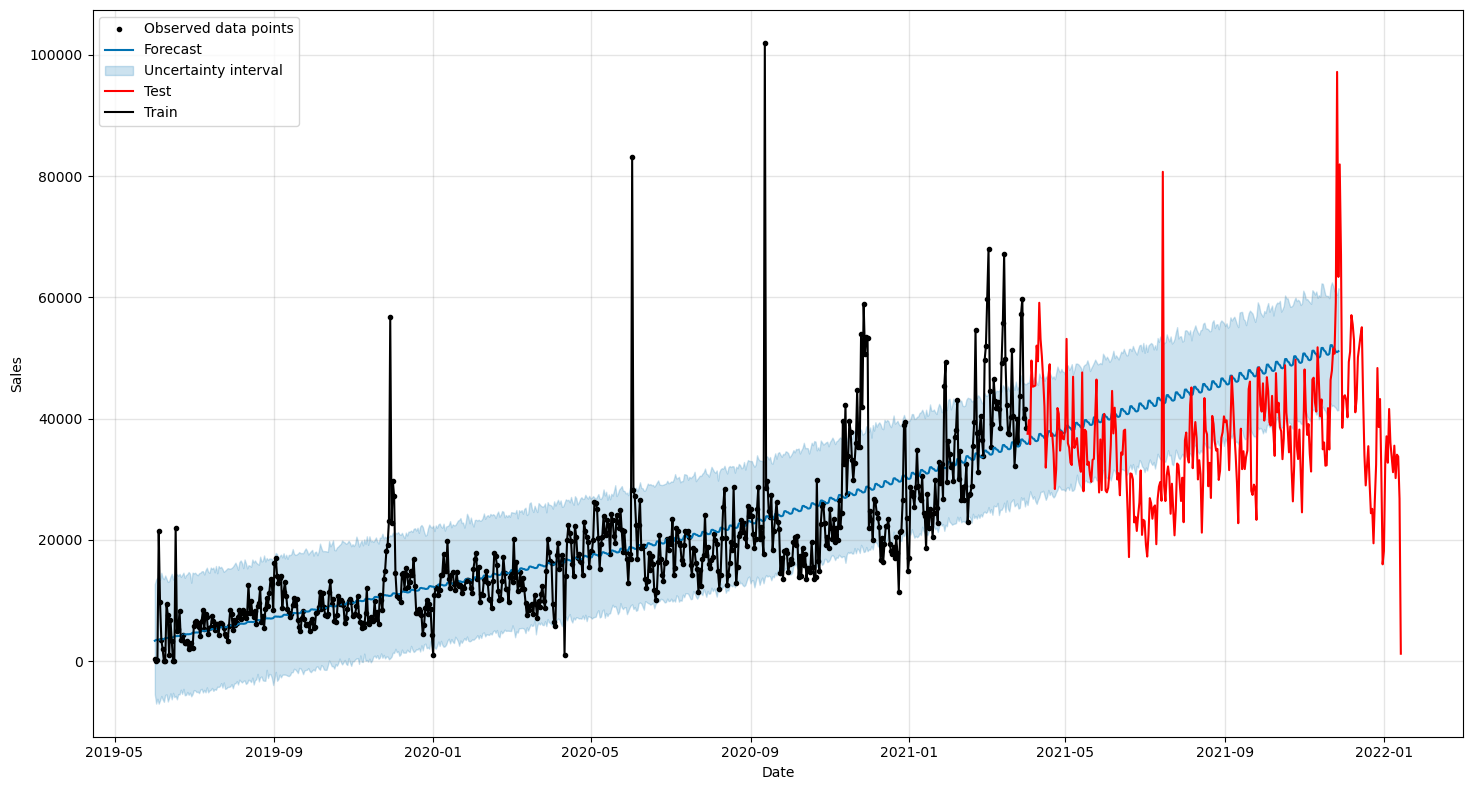

In [19]:
fig, ax = plt.subplots(figsize=(15, 8))

final_model.plot(final_forecast, ax=ax)
ax.plot(test.ds, test.y, color='r', label='Test')
ax.plot(train.ds, train.y, color='black', label='Train')
plt.legend()
ax.set_xlabel('Date')
ax.set_ylabel('Sales')

Text(0.5, 1.0, 'Forecast vs Actual Daily Sales')

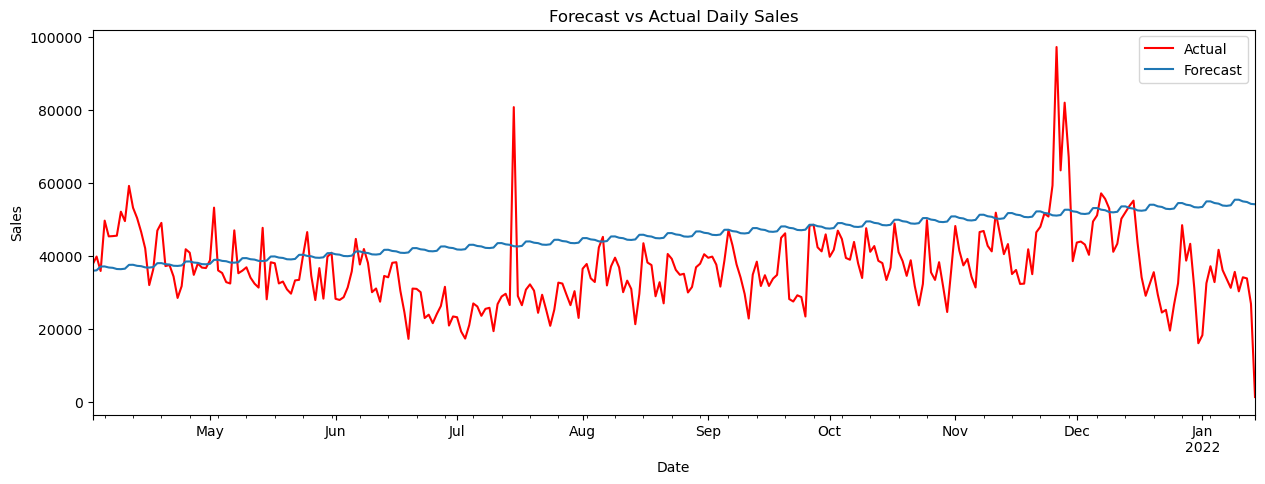

In [20]:
test_forecast = final_model.predict(test)

fig, ax = plt.subplots(figsize=(14, 5))
fig.set_figheight(5)
fig.set_figwidth(15)

test.plot(x='ds', y='y', color='r', label='Actual', ax=ax)
test_forecast.plot(x='ds', y='yhat', label='Forecast', ax=ax)
plt.legend()
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.title('Forecast vs Actual Daily Sales')


In [21]:
# predict one year into the future
future = final_model.make_future_dataframe(periods=730)
forecast = final_model.predict(future)

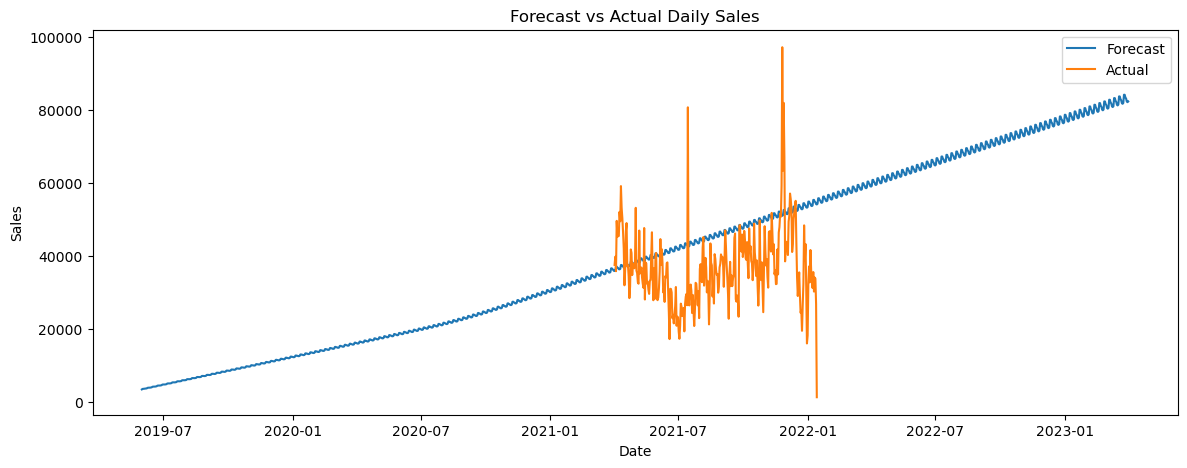

In [22]:
future = final_model.make_future_dataframe(periods=730, freq='D')
final_forecast = final_model.predict(future)

fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(final_forecast['ds'], final_forecast['yhat'], label='Forecast')
ax.plot(test['ds'], test['y'], label='Actual')
ax.legend()
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.title('Forecast vs Actual Daily Sales')
plt.show()

In [23]:
# look at 'yhat', 'yhat_lower', and 'yhat_upper':
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2019-06-01,3376.687363,-6027.364016,13072.732135
1,2019-06-02,3510.216264,-7238.144329,12736.429791
2,2019-06-03,3548.408948,-6076.248731,12382.805241
3,2019-06-04,3556.437352,-6186.906813,12723.618628
4,2019-06-05,3582.879112,-6182.649117,12917.299423


In [24]:
# look at 'yhat', 'yhat_lower', and 'yhat_upper':
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1396,2023-03-28,83389.982040,72894.449055,93274.224778
1397,2023-03-29,83101.540526,72536.971344,94058.663648
1398,2023-03-30,82278.314529,71981.469742,92410.690487
1399,2023-03-31,82103.902859,71811.591512,92071.565570
1400,2023-04-01,82314.176881,72013.029958,93182.711916


## Sales Growth

In [25]:
# find total predicted sales revenue sum so we can compare later to original sales revenue 

start_date = '2022-01-15'
end_date = '2023-01-14'

# filter dataframe for date range
forecast_filtered = forecast[(forecast['ds'] >= start_date) & (forecast['ds'] <= end_date)]

# calculate sum of yhat column
total_sum_forecast = forecast_filtered['yhat'].sum()

print(f'The total sum of the yhat column from {start_date} to {end_date} is: {total_sum_forecast:.2f}')

The total sum of the yhat column from 2022-01-15 to 2023-01-14 is: 24300887.78


In [27]:
# rename the 'ds' column in the forecast dataframe to 'date'
forecast = forecast.rename(columns={'ds': 'date'})

# rename the 'ds' column in the df_country dataframe to 'date'
df_product = df_product.rename(columns={'ds': 'date'})

# rename the 'y' column in the df_country dataframe to 'sales_revenue'
df_product = df_product.rename(columns={'y': 'sales_revenue'})

# merge the forecast dataframe with df_daily on 'date'
forecast_product_df = pd.merge(df_product, forecast[['date', 'yhat']], on='date', how='left')

# rename the 'yhat' column to 'forecast_sales_revenue'
forecast_product_df = forecast_product_df.rename(columns={'yhat': 'forecast_sales_revenue'})

# print the merged dataframe
forecast_product_df.head()

,date,sales_revenue,forecast_sales_revenue
0,2019-06-01,414.715662,3376.687363
1,2019-06-02,0.000000,3510.216264
2,2019-06-03,237.346124,3548.408948
3,2019-06-04,21472.842993,3556.437352
4,2019-06-05,9736.911843,3582.879112


In [29]:
filtered_df = forecast_product_df[(forecast_product_df['date'] >= '2021-01-14') & (forecast_product_df['date'] <= '2022-01-14')]

total_sales_revenue = filtered_df['sales_revenue'].sum()

print(total_sales_revenue)

13466012.6373912


In [31]:
percentage_increase = ((total_sum_forecast - total_sales_revenue) / total_sales_revenue) * 100
print(f'The sales revenue increase year over year in {product_name} is: {percentage_increase:.2f}%')

The sales revenue increase year over year in Running shoes is: 80.46%
